**Credit Card Lead Prediction**

**Problem Statement** : 

Happy Customer Bank is a mid-sized private bank that deals in all kinds of banking products, like Savings accounts, Current accounts, investment products, credit products, among other offerings.
The bank also cross-sells products to its existing customers and to do so they use different kinds of communication like tele-calling, e-mails, recommendations on net banking, mobile banking, etc. 
In this case, the Happy Customer Bank wants to cross sell its credit cards to its existing customers. The bank has identified a set of customers that are eligible for taking these credit cards.
Now, the bank is looking for your help in identifying customers that could show higher intent towards a recommended credit card, given:
Customer details (gender, age, region etc.)
Details of his/her relationship with the bank (Channel_Code,Vintage, 'Avg_Asset_Value etc.)







**Step 1 : Import necessary libraries**

In [74]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from hyperopt import hp, fmin, tpe,Trials,STATUS_OK
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

In [75]:
!pip install catboost
from catboost import CatBoostClassifier

**Step 2 : Data Inspection**

In [144]:
train = pd.read_csv("train_s3TEQDk.csv")
test = pd.read_csv("test_mSzZ8RL.csv")
train.shape,test.shape  # Number of rows and columns for train and test dataset

((245725, 11), (105312, 10))

In [ ]:
train.head() # Display the first five rows of train data

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
0,NNVBBKZB,Female,73,RG268,Other,X3,43,No,1045696,No,0
1,IDD62UNG,Female,30,RG277,Salaried,X1,32,No,581988,No,0
2,HD3DSEMC,Female,56,RG268,Self_Employed,X3,26,No,1484315,Yes,0
3,BF3NC7KV,Male,34,RG270,Salaried,X1,19,No,470454,No,0
4,TEASRWXV,Female,30,RG282,Salaried,X1,33,No,886787,No,0


**Step 3 : Check for missing values**

In [5]:
train.isnull().sum() # Check for missing values

ID                         0
Gender                     0
Age                        0
Region_Code                0
Occupation                 0
Channel_Code               0
Vintage                    0
Credit_Product         29325
Avg_Account_Balance        0
Is_Active                  0
Is_Lead                    0
dtype: int64

In [145]:
dataset = [train,test] # Credit_Product column has null values in both train and test dataset. Impute the missing values with 'Yes'
for data in dataset:
  data['Credit_Product']= data['Credit_Product'].replace(np.nan,'Yes')
 

In [79]:
train.isnull().sum() # Check again if missing values are removed.

ID                     0
Gender                 0
Age                    0
Region_Code            0
Occupation             0
Channel_Code           0
Vintage                0
Credit_Product         0
Avg_Account_Balance    0
Is_Active              0
Is_Lead                0
dtype: int64

**Step 4: Convert categorical data to numerical values**

In [152]:
columns = ['Gender','Region_Code','Occupation','Channel_Code','Credit_Product','Is_Active']
le = LabelEncoder() # Use label encoding technique
dataset =[train,test]# convert categorical to numerical values
for data in dataset:
    for c in columns:
        data[c] = le.fit_transform(data[c]) 

 **Step 5: Data visualization**

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


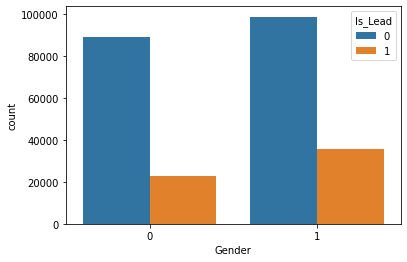

In [135]:
sns.countplot(train['Gender'],hue = train['Is_Lead']) 

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


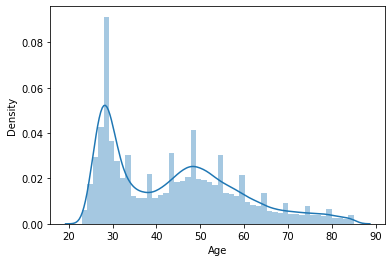

In [136]:
sns.distplot(train['Age'])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


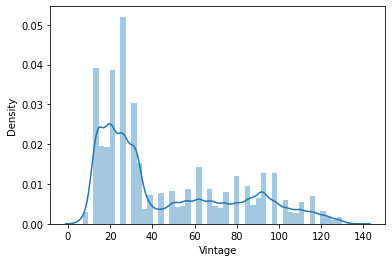

In [137]:
sns.distplot(train['Vintage'])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


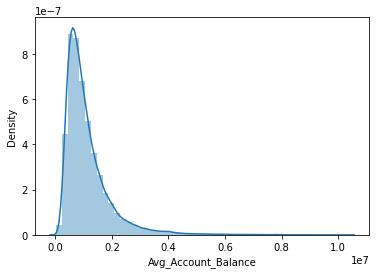

In [138]:
sns.distplot(train['Avg_Account_Balance'])

In [148]:
dataset =[ train,test] # Avg_Account_Balance distribution is skewed towards left.
for data in dataset: # Apply logarithmic transformation
    data['Avg_Account_Balance'] = np.log(data['Avg_Account_Balance']) 

In [139]:
#@title
train.head()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
0,NNVBBKZB,0,73,18,1,2,43,0,1045696,0,0
1,IDD62UNG,0,30,27,2,0,32,0,581988,0,0
2,HD3DSEMC,0,56,18,3,2,26,0,1484315,1,0
3,BF3NC7KV,1,34,20,2,0,19,0,470454,0,0
4,TEASRWXV,0,30,32,2,0,33,0,886787,0,0


In [140]:
train.describe()

,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
count,245725.000000,245725.000000,245725.000000,245725.000000,245725.000000,245725.000000,245725.000000,2.457250e+05,245725.000000,245725.000000
mean,0.546127,43.856307,19.873297,2.103282,0.902867,46.959141,0.412526,1.128403e+06,0.388381,0.237208
std,0.497869,14.828672,10.866718,0.853751,0.884840,32.353136,0.492290,8.529364e+05,0.487383,0.425372
min,0.000000,23.000000,0.000000,0.000000,0.000000,7.000000,0.000000,2.079000e+04,0.000000,0.000000
25%,0.000000,30.000000,11.000000,1.000000,0.000000,20.000000,0.000000,6.043100e+05,0.000000,0.000000
50%,1.000000,43.000000,19.000000,2.000000,1.000000,32.000000,0.000000,8.946010e+05,0.000000,0.000000
75%,1.000000,54.000000,30.000000,3.000000,2.000000,73.000000,1.000000,1.366666e+06,1.000000,0.000000
max,1.000000,85.000000,34.000000,3.000000,3.000000,135.000000,1.000000,1.035201e+07,1.000000,1.000000


In [141]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 245725 entries, 0 to 245724
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ID                   245725 non-null  object
 1   Gender               245725 non-null  int64 
 2   Age                  245725 non-null  int64 
 3   Region_Code          245725 non-null  int64 
 4   Occupation           245725 non-null  int64 
 5   Channel_Code         245725 non-null  int64 
 6   Vintage              245725 non-null  int64 
 7   Credit_Product       245725 non-null  int64 
 8   Avg_Account_Balance  245725 non-null  int64 
 9   Is_Active            245725 non-null  int64 
 10  Is_Lead              245725 non-null  int64 
dtypes: int64(10), object(1)
memory usage: 20.6+ MB


**Step 6: Building the model and Evaluation of model using roc_auc_score**

In [150]:
X= train.drop(columns = ['ID','Is_Lead'], axis=1) #input features 
y= train['Is_Lead']#target feature

In [151]:
Folds= 10       # Stratified k fold with catboost model
rocaucscore =[]
fold = StratifiedKFold(n_splits=Folds, shuffle=True, random_state=2020)
i = 1

for train_index, test_index in fold.split(X, y):
    x_train, x_val = X.iloc[train_index], X.iloc[test_index]
    y_train, y_val = y.iloc[train_index], y.iloc[test_index]
    
    m =  CatBoostClassifier(n_estimators=20000,random_state=2020,eval_metric='AUC')
    
    m.fit(x_train, y_train,eval_set=[(x_val, y_val)], early_stopping_rounds=100,verbose=100)
    
    pred_y = m.predict_proba(x_val)[:,1] 
    
    print(i, " rocaucscore: ", roc_auc_score(y_val,pred_y))
    rocaucscore.append(roc_auc_score(y_val,pred_y))
    i = i + 1


Learning rate set to 0.032666
0:	test: 0.8402449	best: 0.8402449 (0)	total: 93.5ms	remaining: 31m 10s
100:	test: 0.8500497	best: 0.8500497 (100)	total: 7.74s	remaining: 25m 24s
200:	test: 0.8513542	best: 0.8513542 (200)	total: 15.2s	remaining: 25m 1s
300:	test: 0.8519208	best: 0.8519432 (298)	total: 22.9s	remaining: 24m 56s
400:	test: 0.8521488	best: 0.8521488 (400)	total: 30.6s	remaining: 24m 54s
500:	test: 0.8522393	best: 0.8522393 (500)	total: 38.3s	remaining: 24m 51s
600:	test: 0.8521355	best: 0.8522716 (518)	total: 46.1s	remaining: 24m 48s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8522716335
bestIteration = 518

Shrink model to first 519 iterations.
1  rocaucscore:  0.8522716335390761
Learning rate set to 0.032666
0:	test: 0.8402095	best: 0.8402095 (0)	total: 79ms	remaining: 26m 19s
100:	test: 0.8489245	best: 0.8489245 (100)	total: 7.82s	remaining: 25m 40s
200:	test: 0.8498166	best: 0.8498245 (199)	total: 15.4s	remaining: 25m 15s
300:	test: 0.8499059	bes

In [125]:
pred8= m.predict_proba(x_val)[:,1]
roc_auc_score(y_val,pred8)

0.8513031914821949

In [ ]:
test1 = test.copy()
test1 = test1.drop('ID',axis=1)

In [111]:
pred8 = m.predict_proba(test1)[:,1]

In [115]:
res = pd.DataFrame({"ID":test.ID.values,"Is_Lead": pred8}) #final predictions of model on input features of  new unseen test data
res.index = test.index # test index for comparison.
res.to_csv("new9.csv", index=False) # save to csv file